# Notebook to plot discharging curves derived with COMSOL
### Mesh downsampling RVE-analysis

Goal here is to have a reliable plot script that works for any amount of data. Each simulation in comsol multiphysics produces an excel file for two c-rates (-1/-3). This script is tailored to a downsampling - analysis. I want to be able to compare the results of the same simulations run with different mesh-sizes to each other. Therefore, the results need to be put into a folder called 'input_results'. The name of the excel files should contain the mesh size (position 14:17). This can of course be altered. You will get two plots, one for 1 c-rate and on for 3 c-rates.

In [86]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os

def loop_directory(directory):
    '''
    loop through input directory and return list of files (excel files containing simulation results in this case)
    returns dataframe containing list of files in input directory
    '''
    f_list = []
    name_list = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            f_list.append(f)
    print(f_list)
    return f_list

def sort_input_data (input_file,name):
    """
    separates original df into two dataframes by c_rates (-1 and -3)
    returns two dfs, one for each c-rate
    """
    #read input dataframe
    df = pd.read_excel(input_file, skiprows = 4)
    #rename columns for easier handling
    df = df.rename(columns = {'Elektrisches Potential auf dem Rand (V)':name, 't (s)' : 'time'})
    #set c_rate as index
    df = df.set_index('c_rate')
    #filter and create two different dataframes containing the individual voltages for corresponding c_rates (1/3) - will always stay the same
    df_c_1 = df.filter(like = '-1', axis = 0).set_index('time')
    df_c_3 = df.filter(like = '-3', axis = 0).set_index('time')
    return df_c_1, df_c_3

def merge_similar_simulations(directory):
    '''
    merge the dataframes for results with same c_rates but different mesh-sizes into one df to be plotted
    returns two dataframes that contain the voltages for each mesh size for the same c-rate
    works for any amount of data
    '''
    f_list = loop_directory(directory) #get list of files in input folder
    df_c1 = pd.DataFrame()#make empty df for 1c-rate
    df_c3 = pd.DataFrame()#make empty df for 3c-rates
    
    for i,f in enumerate(f_list):
        name = f[14:17] #name = characters 14-15 from excel_list
        df_temp_c1, df_temp_c3 = sort_input_data(f,name)#temporary dfs for each excel file, already sorted by c-rate
        
        if i == 0:
            df_c1 = df_temp_c1
            df_c3 = df_temp_c3
        else:
            df_c1 = pd.merge(df_c1, df_temp_c1, how='right', on = 'time')
            df_c3 = pd.merge(df_c3, df_temp_c3, how='right', on = 'time')
            
    df_c1 = df_c1.reset_index(drop = False)
    df_c3 = df_c3.reset_index(drop = False)

    return df_c1, df_c3

directory = 'input_results'
df_c1, df_c3 = merge_similar_simulations(directory)
df_c3.head()

['input_results/-50.xlsx', 'input_results/-10.xlsx', 'input_results/-40.xlsx', 'input_results/-20.xlsx']


,time,-50,-10,-40,-20
0,0.000000,4.155599,4.151485,4.155588,4.153806
1,8.333333,4.112542,4.096182,4.111708,4.103815
2,16.666667,4.093205,4.074839,4.092112,4.082657
3,25.000000,4.078211,4.058830,4.076962,4.067055
4,33.333333,4.065523,4.045579,4.064028,4.054023


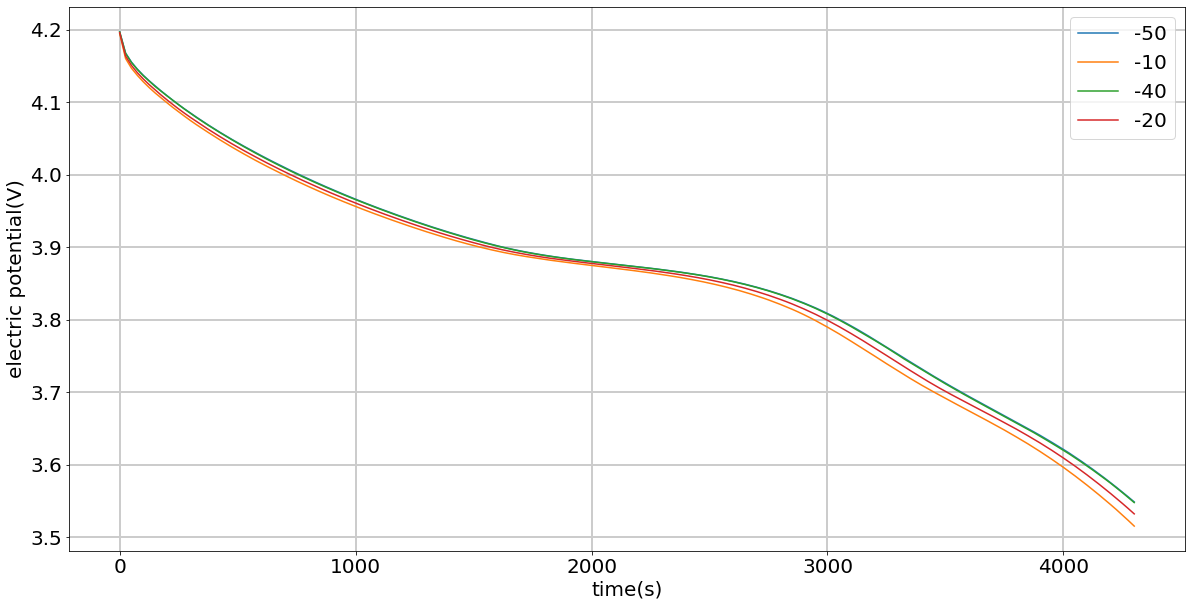

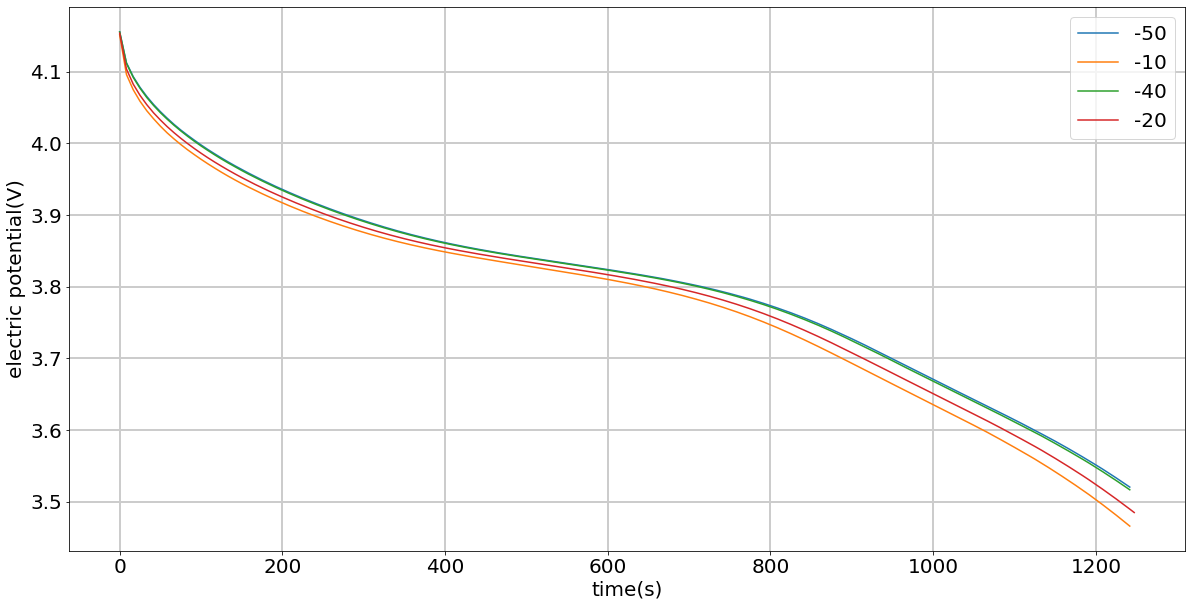

In [77]:
def make_plot (df_ir, x_axis_label, y_axis_label, name):
    '''
    takes df as input and plots first column as x-axis and the resulting columns on top of each other
    '''
    save_name = 'outputs/' + name #name to be saved later on
    plt.figure(figsize = (20, 10))#figure size
    
    headers = df_ir.columns.values
    x = headers[0]#set as x-axis
    for i,c in enumerate(headers, 0):
        if i > 0:
            plt.plot(df_ir[x], df_ir[c], label = c)
            #plt.plot(x, df_ir[c], label = c)
    label_size = 20
    
    plt.grid(True, color='0.8', linestyle='-', linewidth=2)
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)
    plt.xlabel(x_axis_label, fontsize=label_size)
    plt.ylabel(y_axis_label, fontsize=label_size)
    
    plt.legend(df_ir.columns.values[1:], loc='upper right', fontsize=label_size)
    plt.savefig(save_name)
    plt.show()
    return

y_axis_label = "electric potential(V)"
x_axis_label = "time(s)"

make_plot(df_c1, x_axis_label, y_axis_label, 'c_1')
make_plot(df_c3, x_axis_label, y_axis_label, 'c_3')